In [1]:
# import dependencies
import yfinance as yf
import pandas as pd
from prophet import Prophet

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import os
import requests
import json
from dotenv import load_dotenv


## Step 1 : Retrieve Stock Data with the yFinance SDK
1. **Get the Top 3 Companies by Sector:**
    - Use the `yFinance` SDK to retrieve a list of the top 3 companies within each sector.
2. **Obtain 5 years of Historical Data.**
    - Pull historical stock data for each of these companies, covering the past 5 years to analyze performance and trends.

In [2]:
# Define the sectors to analyze
sectors = ['technology', 'healthcare', 'financial-services', 'energy', 'consumer-cyclical']
top_sector_dfs = []

for sector in sectors:

    # Retrieve the top companies in the current sector (outputs a DataFrame)
    top_companies = yf.Sector(sector).top_companies

    # Filter out records where the 'rating' column is None to avoid any issues
    # and retrieve the top 3 companies with a valid rating
    top_3_companies = top_companies[top_companies['rating'].notna()].head(3)

    # Add a 'sector' column to identify the sector for each company
    top_3_companies['sector'] = sector

    # Append the DataFrame to the list for later concatenation
    top_sector_dfs.append(top_3_companies)
    
# Combine all sector data into a single DataFrame
top_companies_df = pd.concat(top_sector_dfs, axis=0)
top_companies_df

,name,rating,market weight,sector
symbol,,,,
NVDA,NVIDIA Corporation,Buy,0.186485,technology
AAPL,Apple Inc.,Buy,0.176786,technology
MSFT,Microsoft Corporation,Buy,0.164434,technology
LLY,Eli Lilly and Company,Buy,0.115299,healthcare
UNH,UnitedHealth Group Incorporated,Buy,0.082690,healthcare
JNJ,Johnson & Johnson,Buy,0.054844,healthcare
BRK-B,Berkshire Hathaway Inc.,Buy,0.099877,financial-services
JPM,JPMorgan Chase & Co.,Buy,0.080602,financial-services
V,Visa Inc.,Buy,0.059630,financial-services


In [3]:
# Get all the symbols into a list
tickers = top_companies_df.index.to_list()
print(tickers)

['NVDA', 'AAPL', 'MSFT', 'LLY', 'UNH', 'JNJ', 'BRK-B', 'JPM', 'V', 'XOM', 'CVX', 'COP', 'AMZN', 'TSLA', 'HD']


In [4]:
# Dictionary to store historical data for each ticker
historical_data = {}

for ticker in tickers:
    
    # Initialize the ticker object
    stock = yf.Ticker(ticker)

    # Retrieve 5 years of historical market data for the current ticker
    historical_data[ticker] = stock.history(period="5y")

    # Add the ticker symbol as a column to the DataFrame
    historical_data[ticker]['Symbol'] = ticker


In [5]:
# Create a DataFrame for the historical data
historical_df = pd.concat(historical_data, axis = 0)

# Display the first 5 and last 5 rows of the DataFrame
display(historical_df.head(5))
display(historical_df.tail(5))

Open      High       Low     Close  \
     Date                                                                
NVDA 2019-11-13 00:00:00-05:00  5.183540  5.211156  5.122587  5.189014   
     2019-11-14 00:00:00-05:00  5.197968  5.221603  5.138009  5.219364   
     2019-11-15 00:00:00-05:00  5.217123  5.268871  4.991719  5.080040   
     2019-11-18 00:00:00-05:00  5.072578  5.307933  5.069593  5.281313   
     2019-11-19 00:00:00-05:00  5.250213  5.273848  5.116364  5.174581   

                                    Volume  Dividends  Stock Splits Symbol  
     Date                                                                   
NVDA 2019-11-13 00:00:00-05:00   300188000        0.0           0.0   NVDA  
     2019-11-14 00:00:00-05:00   518080000        0.0           0.0   NVDA  
     2019-11-15 00:00:00-05:00  1053628000        0.0           0.0   NVDA  
     2019-11-18 00:00:00-05:00   574588000        0.0           0.0   NVDA  
     2019-11-19 00:00:00-05:00   414564000        0.0           0.0   NVDA

Open        High         Low       Close  \
   Date                                                                        
HD 2024-11-07 00:00:00-05:00  391.000000  399.760010  390.799988  399.440002   
   2024-11-08 00:00:00-05:00  404.000000  406.399994  402.299988  405.899994   
   2024-11-11 00:00:00-05:00  407.769989  411.600006  405.829987  408.290009   
   2024-11-12 00:00:00-05:00  414.250000  416.019989  402.190002  403.079987   
   2024-11-13 00:00:00-05:00  409.130005  412.739899  406.720093  408.890015   

                               Volume  Dividends  Stock Splits Symbol  
   Date                                                                
HD 2024-11-07 00:00:00-05:00  4323100        0.0           0.0     HD  
   2024-11-08 00:00:00-05:00  3448700        0.0           0.0     HD  
   2024-11-11 00:00:00-05:00  4071500        0.0           0.0     HD  
   2024-11-12 00:00:00-05:00  5641900        0.0           0.0     HD  
   2024-11-13 00:00:00-05:00  1485206        0.0           0.0     HD

In [6]:
# The dataframe has multiple indices.  So, we need to drop the first and just keep the Date as index
historical_df = historical_df.reset_index(level=0, drop=True)

# Convert the index to datetime
historical_df.index = pd.to_datetime(historical_df.index)

# Remove the timestamp and keep only the date part
historical_df.index = historical_df.index.date

# Display the DataFrame to check
display(historical_df.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183540,5.211156,5.122587,5.189014,300188000,0.0,0.0,NVDA
2019-11-14,5.197968,5.221603,5.138009,5.219364,518080000,0.0,0.0,NVDA
2019-11-15,5.217123,5.268871,4.991719,5.080040,1053628000,0.0,0.0,NVDA
2019-11-18,5.072578,5.307933,5.069593,5.281313,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA


## Step 2 : Create visuals to determine interesting patters within these stocks

1. A regular (linear scale) graph to observe absolute price growth.
2. A logarithmic scale graph to focus on relative (percentage-based) growth.

- **Regular Scale Graph:** Highlights the absolute stock price increases over time. This graph is particularly useful for identifying which stock has the highest dollar-value growth.

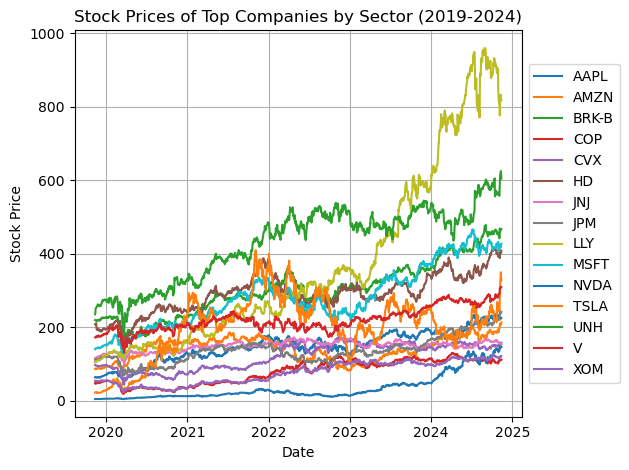

In [7]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

- **Logarithmic Scale Graph:** Emphasizes the relative (percentage) growth of each stock, making it easier to compare growth rates.

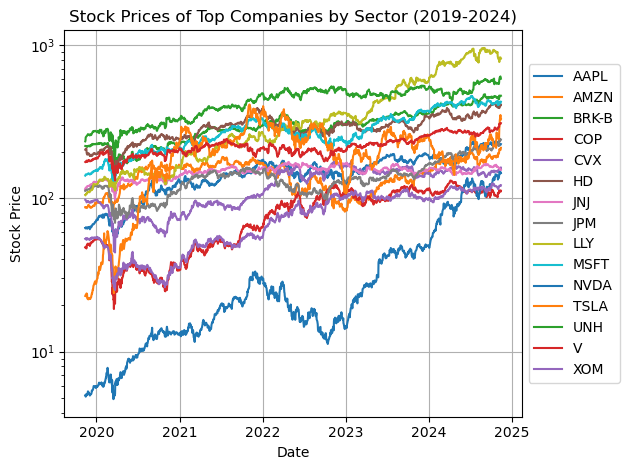

In [8]:
# plot the visualization for the stock price

historical_df.groupby('Symbol')['Close'].plot()

# Log scale on y-axis
plt.yscale('log')

# Add the legend to the visual
plt.legend(title = 'Ticker')

plt.title("Stock Prices of Top Companies by Sector (2019-2024)")
plt.grid(True)

# Add the axis labels
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Adjust legend placement
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the graph with the added features
plt.tight_layout()
plt.show()

**Question:** What pattern looks more interesting?

**LLY (Eli Lilly)** and **NVDA (NVIDIA)** seem to be the interesting candidates for further analysis with financial data, as they both exhibit standout patterns that suggest potential insights:
- **LLY (Eli Lilly)** shows the most notable absolute price increase, suggesting strong performance in dollar terms. 
- **NVDA (NVIDIA)** has experienced the highest relative growth over the period, which is interesting because it indicates a dramatic percentage increase from its initial value.


In [9]:
# Filter the DataFrame to keep only rows with 'Symbol' as 'NVDA' or 'LLY'
historical_df= historical_df.loc[historical_df['Symbol'].isin(['NVDA', 'LLY'])]

# Display the first and last 5 records to verify the slice
display(historical_df.head())
display(historical_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183540,5.211156,5.122587,5.189014,300188000,0.0,0.0,NVDA
2019-11-14,5.197968,5.221603,5.138009,5.219364,518080000,0.0,0.0,NVDA
2019-11-15,5.217123,5.268871,4.991719,5.080040,1053628000,0.0,0.0,NVDA
2019-11-18,5.072578,5.307933,5.069593,5.281313,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.0,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.0,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.0,0.0,LLY
2024-11-12,830.200012,833.989990,810.719971,818.859985,3376300,0.0,0.0,LLY
2024-11-13,820.320007,829.104980,816.219971,817.549988,1530214,0.0,0.0,LLY


---

## Step 3: Retrieve Financial Data with the Alpha Vantage API

1. **Get Income Statement and Cash Flow Data:**
    - Use the Alpha Vantage API to retrieve financial data for each company, including the Income Statement and Cash Flow reports.
    - Focus on key metrics such as `Total Revenue` and `Free Cash Flow` to assess financial health.

2. **Calculate Net Profit Margin:**
    - From the Income Statement, use `Net Profit` and `Total Revenue` to calculate the **Net Profit Margin** for each company, which helps measure profitability.

In [10]:
# Load environment variables from the .env file
load_dotenv()

# Access the ALPHA_API_KEY
alpha_api_key = os.getenv("ALPHA_API_KEY")


In [11]:
# List of tickers selected for further analysis
selected_tickers = ['LLY', 'NVDA']

### Retrieve Income Statements Data

In [12]:
# Initialize an empty list to store quarterly income statements for each ticker
alpha_quarterly_income_statements = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the income statement data for the current ticker
    url = f"https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(url).json()
    
    # Loop through each quarterly report in the response (if available)
    for report in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        report["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_income_statements.append(response.get("quarterlyReports", []))

In [14]:
# Initialize an empty list to store the extracted data
income_statements_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_income_statements:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Gross Profit': int(_['grossProfit']), 
            'Total Revenue': int(_['totalRevenue'])
        }
        
        # Append the dictionary to the data list
        income_statements_data.append(record)

In [15]:
# Create a DataFrame from the data and set 'Date' as the index
income_statements_df = pd.DataFrame(income_statements_data).set_index('Date')

# Show the first and last 5 records
display(income_statements_df.head())
display(income_statements_df.tail())

,Symbol,Gross Profit,Total Revenue
Date,,,
2024-09-30,LLY,7202300000,11439100000
2024-06-30,LLY,6694700000,11302800000
2024-03-31,LLY,5258400000,8768000000
2023-12-31,LLY,5182500000,9353400000
2023-09-30,LLY,5950100000,9498600000


,Symbol,Gross Profit,Total Revenue
Date,,,
2009-07-26,NVDA,156723000,776520000
2009-04-26,NVDA,189696000,664231000
2009-01-25,NVDA,141666000,481140000
2008-10-26,NVDA,367843000,897655000
2008-07-27,NVDA,149917000,892676000


### Retrieve Cashflow data

In [16]:
# Initialize an empty list to store quarterly CashFlow for each ticker
alpha_quarterly_cashflow = []

# Loop through each ticker in the selected tickers list
for ticker in selected_tickers:
    
    # Construct the API URL to fetch the Cash Flow data for the current ticker
    casflow_url = f"https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={alpha_api_key}"
    
    # Send a GET request to the API and retrieve the response in JSON format
    response = requests.get(casflow_url).json()
    
    # Loop through each quarterly report in the response (if available)
    for _ in response.get("quarterlyReports", []):
        # Add the ticker symbol to each report to identify the data's source
        _["symbol"] = ticker

    # Append the list of quarterly reports to the main list (or an empty list if no reports are available)
    alpha_quarterly_cashflow.append(response.get("quarterlyReports", []))

In [17]:
# Initialize an empty list to store the extracted data
cashflow_data= []

# Loop through each quarterly report in the ticker's income statements
for ticker in alpha_quarterly_cashflow:

    for _ in ticker: 
        
         # Create a dictionary for the extracted fields
        record = {
            'Date': pd.to_datetime(_['fiscalDateEnding']), 
            'Symbol': _['symbol'], 
            'Operating Cashflow': int(_['operatingCashflow']), 
            'Capital Expenditures': int(_['capitalExpenditures']),
            'Net Income': int(_['netIncome'])
        }
        
        # Append the dictionary to the data list
        cashflow_data.append(record)

In [18]:
# Create a DataFrame from the data and set 'Date' as the index
cashflow_df = pd.DataFrame(cashflow_data).set_index('Date')

# Show the first and last 5 records
display(cashflow_df.head())
display(cashflow_df.tail())

,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2024-09-30,LLY,3711900000,1350700000,970300000
2024-06-30,LLY,1466200000,1224800000,2967000000
2024-03-31,LLY,1166000000,986300000,2242900000
2023-12-31,LLY,-311900000,1070600000,2189700000
2023-09-30,LLY,2189500000,970300000,-57400000


,Symbol,Operating Cashflow,Capital Expenditures,Net Income
Date,,,,
2010-10-31,NVDA,212177000,21823000,84862000
2010-08-01,NVDA,34344000,37644000,-140961000
2010-05-02,NVDA,-5397000,17080000,137594000
2010-01-31,NVDA,69245000,22575000,131076000
2009-10-25,NVDA,141317000,16593000,107577000


In [19]:
# Calculate Free Cash Flow and add it as a new column
cashflow_df['Free Cash Flow (FCF)'] = cashflow_df['Operating Cashflow'] - cashflow_df['Capital Expenditures']

# Display the first few rows to verify the new column
cashflow_df.head()

,Symbol,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,
2024-09-30,LLY,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,2189500000,970300000,-57400000,1219200000


## Merge the datasets

In [20]:
# Merge the income statements data with cashflow data on 'Date' and 'Symbol'
company_finance_df = pd.merge(income_statements_df, cashflow_df, on=["Date", "Symbol"])

# Set 'Date' as the index in the merged DataFrame
# company_finance_df.set_index("Date", inplace=True)

# Drop the extra 'level_0' and 'index' columns
# company_finance_df = company_finance_df.drop(columns=["level_0", "index"])

# Display the result
display(company_finance_df.head())

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF)
Date,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000


In [21]:
# Calculate 'Net Profit Margin' and add it as a new column
company_finance_df['Net Profit Margin (%)'] = (company_finance_df['Net Income'] / company_finance_df['Total Revenue']) * 100

# Calculate 'Return of Investment (ROI) and add it as a new column
company_finance_df['Return of Investment (ROI)'] = ((company_finance_df['Net Income'] - company_finance_df['Capital Expenditures']) / company_finance_df['Capital Expenditures']) * 100

# Display the first few rows to verify the new column
company_finance_df.head()

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%),Return of Investment (ROI)
Date,,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311,-28.163175
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133,142.243632
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520,127.405455
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738,104.530170
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300,-105.915696


In [22]:
display(historical_df)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183540,5.211156,5.122587,5.189014,300188000,0.0,0.0,NVDA
2019-11-14,5.197968,5.221603,5.138009,5.219364,518080000,0.0,0.0,NVDA
2019-11-15,5.217123,5.268871,4.991719,5.080040,1053628000,0.0,0.0,NVDA
2019-11-18,5.072578,5.307933,5.069593,5.281313,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA
...,...,...,...,...,...,...,...,...
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.0,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.0,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.0,0.0,LLY
2024-11-12,830.200012,833.989990,810.719971,818.859985,3376300,0.0,0.0,LLY


In [23]:
display(company_finance_df)

,Symbol,Gross Profit,Total Revenue,Operating Cashflow,Capital Expenditures,Net Income,Free Cash Flow (FCF),Net Profit Margin (%),Return of Investment (ROI)
Date,,,,,,,,,
2024-09-30,LLY,7202300000,11439100000,3711900000,1350700000,970300000,2361200000,8.482311,-28.163175
2024-06-30,LLY,6694700000,11302800000,1466200000,1224800000,2967000000,241400000,26.250133,142.243632
2024-03-31,LLY,5258400000,8768000000,1166000000,986300000,2242900000,179700000,25.580520,127.405455
2023-12-31,LLY,5182500000,9353400000,-311900000,1070600000,2189700000,-1382500000,23.410738,104.530170
2023-09-30,LLY,5950100000,9498600000,2189500000,970300000,-57400000,1219200000,-0.604300,-105.915696
...,...,...,...,...,...,...,...,...,...
2010-10-31,NVDA,392062000,843912000,212177000,21823000,84862000,190354000,10.055788,288.864959
2010-08-01,NVDA,134292000,811208000,34344000,37644000,-140961000,-3300000,-17.376678,-474.458081
2010-05-02,NVDA,456377000,1001813000,-5397000,17080000,137594000,-22477000,13.734499,705.585480


---

## Visualizations

Symbol
LLY     Axes(0.125,0.11;0.775x0.77)
NVDA    Axes(0.125,0.11;0.775x0.77)
Name: Close, dtype: object

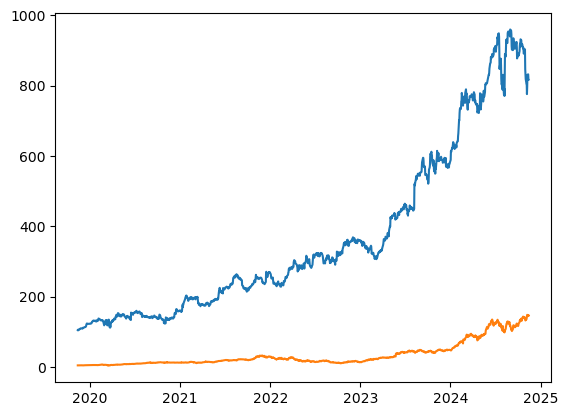

In [25]:
historical_df.groupby('Symbol')['Close'].plot()

In [26]:
df_LLY = historical_df.loc[historical_df['Symbol'] == 'LLY']
df_LLY

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,105.358087,105.974157,104.779347,105.283409,3250600,0.000,0.0,LLY
2019-11-14,105.325655,105.485252,104.208463,104.574600,2627100,0.645,0.0,LLY
2019-11-15,104.518261,106.855908,104.518261,106.264458,4857400,0.000,0.0,LLY
2019-11-18,106.104863,107.146949,105.954657,107.090622,3361600,0.000,0.0,LLY
2019-11-19,107.053055,109.015182,106.790188,108.057587,3781600,0.000,0.0,LLY
...,...,...,...,...,...,...,...,...
2024-11-07,784.650024,802.549988,778.190002,797.450012,4557600,0.000,0.0,LLY
2024-11-08,803.500000,847.270020,801.260010,831.539978,7212900,0.000,0.0,LLY
2024-11-11,831.299988,844.000000,824.630005,832.440002,3342800,0.000,0.0,LLY
2024-11-12,830.200012,833.989990,810.719971,818.859985,3376300,0.000,0.0,LLY


In [27]:
df_NVDA = historical_df.loc[historical_df['Symbol'] == 'NVDA']
df_NVDA

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
2019-11-13,5.183540,5.211156,5.122587,5.189014,300188000,0.0,0.0,NVDA
2019-11-14,5.197968,5.221603,5.138009,5.219364,518080000,0.0,0.0,NVDA
2019-11-15,5.217123,5.268871,4.991719,5.080040,1053628000,0.0,0.0,NVDA
2019-11-18,5.072578,5.307933,5.069593,5.281313,574588000,0.0,0.0,NVDA
2019-11-19,5.250213,5.273848,5.116364,5.174581,414564000,0.0,0.0,NVDA
...,...,...,...,...,...,...,...,...
2024-11-07,146.389999,148.929993,146.169998,148.880005,207323300,0.0,0.0,NVDA
2024-11-08,148.770004,149.770004,146.259995,147.630005,175665800,0.0,0.0,NVDA
2024-11-11,148.679993,148.850006,143.570007,145.259995,182325600,0.0,0.0,NVDA
2024-11-12,146.779999,149.649994,146.009995,148.289993,198023300,0.0,0.0,NVDA


<Axes: >

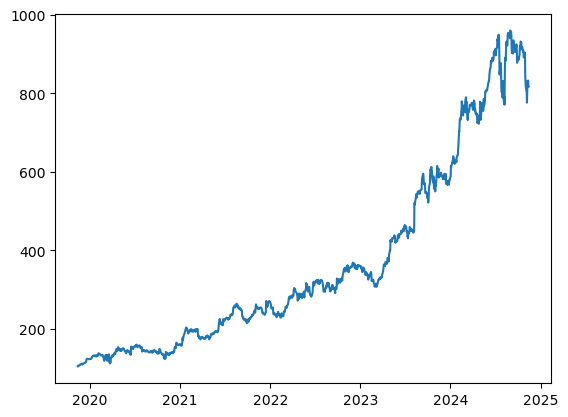

In [28]:
df_LLY['Close'].plot()

<Axes: >

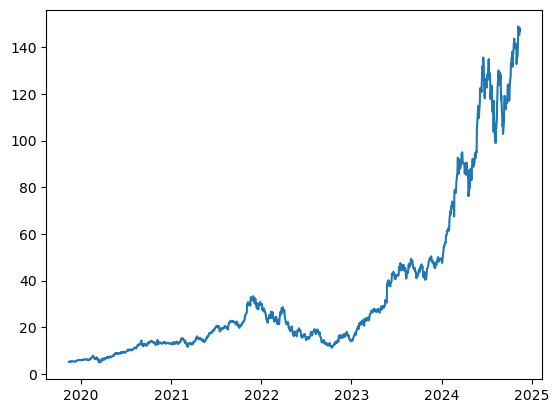

In [29]:
df_NVDA['Close'].plot()

---

## Predictions Using Prophet


### Forecasting **LLY (Eli Lilly)** Future Trends

In [30]:
df_LLY_Trends = df_LLY['Close'].reset_index()

df_LLY_Trends.rename(columns={'index': 'ds', 'Close': 'y'}, inplace=True)

display(df_LLY_Trends.head())
display(df_LLY_Trends.tail())


,ds,y
0,2019-11-13,105.283409
1,2019-11-14,104.574600
2,2019-11-15,106.264458
3,2019-11-18,107.090622
4,2019-11-19,108.057587


,ds,y
1254,2024-11-07,797.450012
1255,2024-11-08,831.539978
1256,2024-11-11,832.440002
1257,2024-11-12,818.859985
1258,2024-11-13,817.549988


In [31]:
# Initializing a new Prophet model
model_LLY_trends = Prophet()

In [32]:
# Training (Fitting) the model on the dataset df_LLY_Trends
model_LLY_trends.fit(df_LLY_Trends)

14:24:18 - cmdstanpy - INFO - Chain [1] start processing
14:24:19 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# Create a dataframe to hold future predictions
# Make the prediction for the next year (365 days)
future_LLY_trends = model_LLY_trends.make_future_dataframe(periods=365 , freq='D')

# View the last five rows of the future_mercado_trends DataFrame
future_LLY_trends.tail()

,ds
1619,2025-11-09
1620,2025-11-10
1621,2025-11-11
1622,2025-11-12
1623,2025-11-13


In [34]:
# Make the predictions for the trend data
forecast_LLY_trends = model_LLY_trends.predict(future_LLY_trends)

# Display the first five rows of the forecast_LLY_trends DataFrame
forecast_LLY_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-13,124.545317,71.406353,137.833097,124.545317,124.545317,-19.408493,-19.408493,-19.408493,3.877449,3.877449,3.877449,-23.285942,-23.285942,-23.285942,0.0,0.0,0.0,105.136824
1,2019-11-14,124.586915,73.596772,138.747281,124.586915,124.586915,-18.438879,-18.438879,-18.438879,3.869649,3.869649,3.869649,-22.308528,-22.308528,-22.308528,0.0,0.0,0.0,106.148036
2,2019-11-15,124.628512,73.653136,138.820558,124.628512,124.628512,-17.176126,-17.176126,-17.176126,4.073420,4.073420,4.073420,-21.249546,-21.249546,-21.249546,0.0,0.0,0.0,107.452386
3,2019-11-18,124.753305,81.003158,143.280451,124.753305,124.753305,-13.789020,-13.789020,-13.789020,4.016291,4.016291,4.016291,-17.805311,-17.805311,-17.805311,0.0,0.0,0.0,110.964285
4,2019-11-19,124.794903,81.315830,145.390614,124.794903,124.794903,-12.785761,-12.785761,-12.785761,3.859164,3.859164,3.859164,-16.644925,-16.644925,-16.644925,0.0,0.0,0.0,112.009141


In [35]:
# Create a Plotly figure
fig = go.Figure()

# Add the forecasted trend line
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat'],
    mode='lines',
    name='Forecasted Trend',
    hovertemplate='Date: %{x}<br>Forecast: %{y:.2f}'
))

# Add the actual data points (if you want to compare them)
fig.add_trace(go.Scatter(
    x=df_LLY_Trends['ds'],
    y=df_LLY_Trends['y'],
    mode='markers',
    name='Actual Data',
    hovertemplate='Date: %{x}<br>Actual: %{y:.2f}'
))

# Add upper and lower forecast boundaries as filled areas
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast_LLY_trends['ds'],
    y=forecast_LLY_trends['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 100, 80, 0.2)',
    name='Confidence Interval',
    hoverinfo='skip'
))

# Customize layout
fig.update_layout(
    title="LLY Forecasted Trend with Prophet",
    xaxis_title="Date",
    yaxis_title="Forecasted Stock Price (Close)",
    hovermode="x unified"
)

# Show the interactive plot
fig.show()


**Analysis:** Based on the plot, it appears that the forecasted trend for LLY (Eli Lilly) shows a continued upward movement, suggesting a positive growth outlook for the stock over the next year.

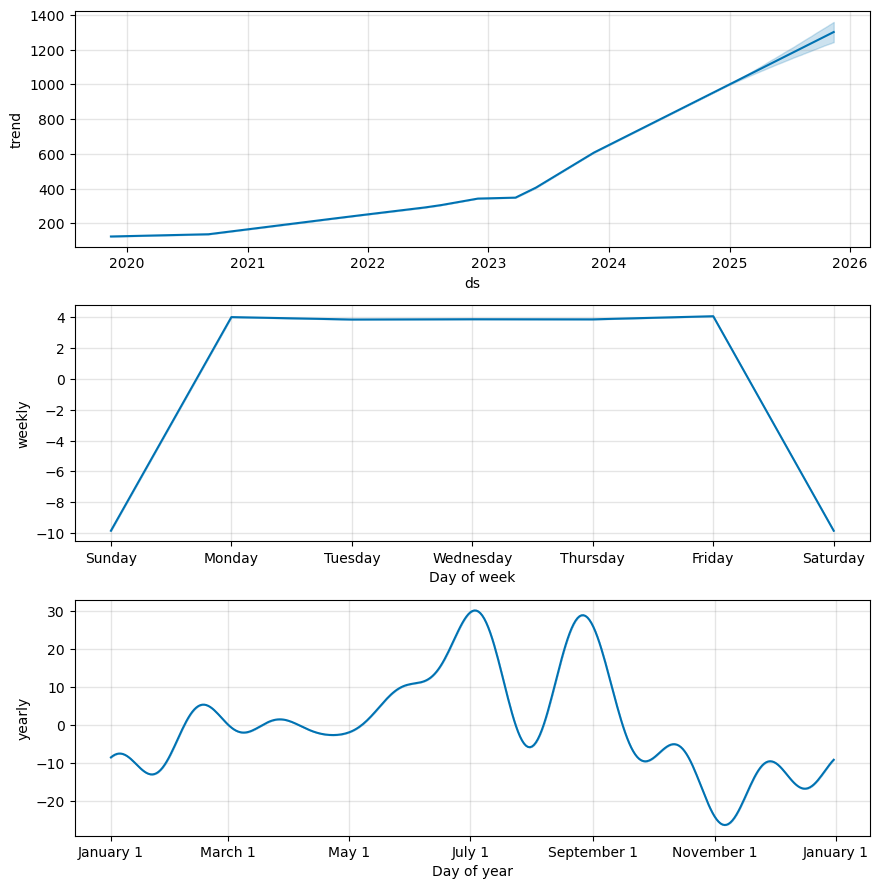

In [42]:
# Plot the yearly seasonality component
figs = model_LLY_trends.plot_components(forecast_LLY_trends)

The yearly trend shows that stock prices generally increase from around May to July, then experience a sharp decline in July. There is a recovery in August, with another rise into September, followed by a steady decline through November.  To further understand this analysis we can look into the data within this period. 

### Forecasting **NVDA (NVIDIA)** Future Trends

In [47]:
df_NVDA_Trends = df_NVDA['Close'].reset_index()

df_NVDA_Trends.rename(columns={'index': 'ds', 'Close': 'y'}, inplace=True)

display(df_NVDA_Trends.head())
display(df_NVDA_Trends.tail())

,ds,y
0,2019-11-13,5.189014
1,2019-11-14,5.219364
2,2019-11-15,5.080040
3,2019-11-18,5.281313
4,2019-11-19,5.174581


,ds,y
1254,2024-11-07,148.880005
1255,2024-11-08,147.630005
1256,2024-11-11,145.259995
1257,2024-11-12,148.289993
1258,2024-11-13,146.945007


In [56]:
# Initializing a new Prophet model
model_NVDA_trends = Prophet()

In [57]:
model_NVDA_trends.fit(df_NVDA_Trends)

15:12:13 - cmdstanpy - INFO - Chain [1] start processing
15:12:14 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
future_NVDA_trends = model_NVDA_trends.make_future_dataframe(periods=365, freq='D')

# View the last five rows of the future_mercado_trends DataFrame
future_NVDA_trends.tail()

,ds
1619,2025-11-09
1620,2025-11-10
1621,2025-11-11
1622,2025-11-12
1623,2025-11-13


In [62]:
# Make the predictions for the trend data
forecast_NVDA_trends = model_NVDA_trends.predict(future_NVDA_trends)

# Display the first five rows of the forecast_LLY_trends DataFrame
forecast_NVDA_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-13,7.172145,2.074645,12.528539,7.172145,7.172145,-0.084961,-0.084961,-0.084961,0.296972,0.296972,0.296972,-0.381933,-0.381933,-0.381933,0.0,0.0,0.0,7.087185
1,2019-11-14,7.168083,2.326608,12.445464,7.168083,7.168083,0.032245,0.032245,0.032245,0.414281,0.414281,0.414281,-0.382036,-0.382036,-0.382036,0.0,0.0,0.0,7.200328
2,2019-11-15,7.164021,1.936438,12.056391,7.164021,7.164021,-0.012810,-0.012810,-0.012810,0.387002,0.387002,0.387002,-0.399812,-0.399812,-0.399812,0.0,0.0,0.0,7.151211
3,2019-11-18,7.151834,1.411807,12.437583,7.151834,7.151834,-0.045027,-0.045027,-0.045027,0.506377,0.506377,0.506377,-0.551404,-0.551404,-0.551404,0.0,0.0,0.0,7.106807
4,2019-11-19,7.147772,1.968821,11.850229,7.147772,7.147772,-0.206695,-0.206695,-0.206695,0.424144,0.424144,0.424144,-0.630839,-0.630839,-0.630839,0.0,0.0,0.0,6.941077


In [63]:
# Create a Plotly figure
fig = go.Figure()

# Add the forecasted trend line
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat'],
    mode='lines',
    name='Forecasted Trend',
    hovertemplate='Date: %{x}<br>Forecast: %{y:.2f}'
))

# Add the actual data points (if you want to compare them)
fig.add_trace(go.Scatter(
    x=df_NVDA_Trends['ds'],
    y=df_NVDA_Trends['y'],
    mode='markers',
    name='Actual Data',
    hovertemplate='Date: %{x}<br>Actual: %{y:.2f}'
))

# Add upper and lower forecast boundaries as filled areas
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast_NVDA_trends['ds'],
    y=forecast_NVDA_trends['yhat_lower'],
    mode='lines',
    fill='tonexty',
    fillcolor='rgba(0, 100, 80, 0.2)',
    name='Confidence Interval',
    hoverinfo='skip'
))

# Customize layout
fig.update_layout(
    title="NVDA Forecasted Trend with Prophet",
    xaxis_title="Date",
    yaxis_title="Forecasted Stock Price (Close)",
    hovermode="x unified"
)

# Show the interactive plot
fig.show()


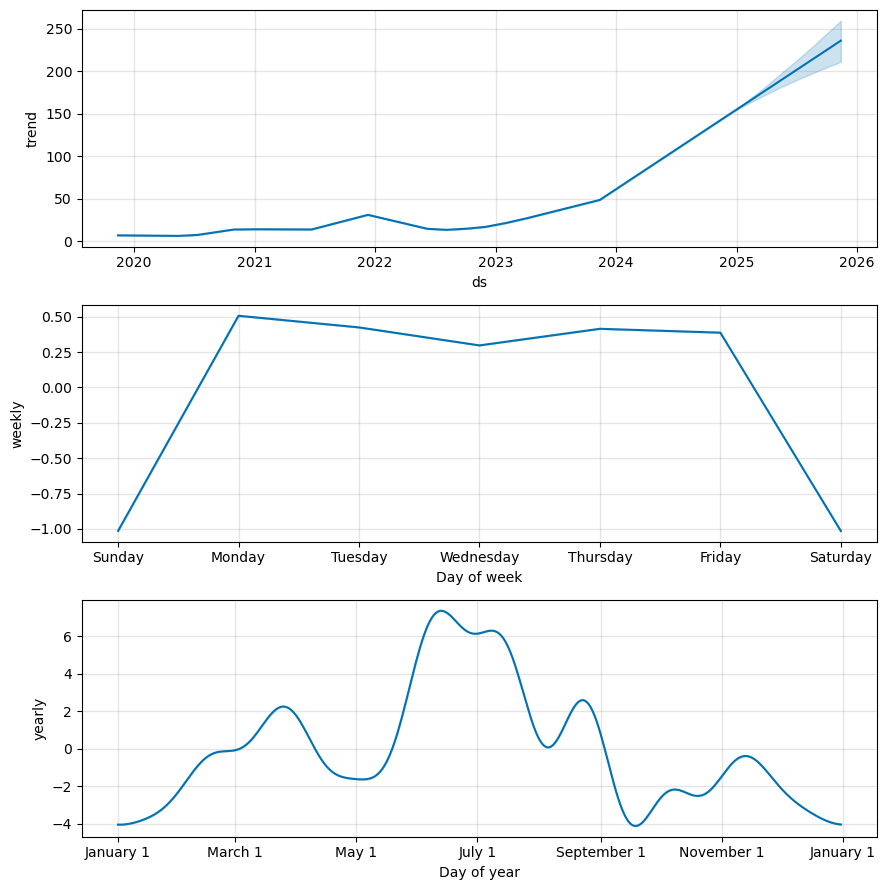

In [65]:
# Plot the yearly seasonality component
figs = model_NVDA_trends.plot_components(forecast_NVDA_trends)

---